## Portfolio Optimization, Example

 **Modern Portfolio Theory**

We look for the best posible portfolio: the one that maximizes the benefit with the lowest level of associated risk. We will use the most popular portfolio performance metric: **Sharpe Ratio**

***Sharpe Ratio = (Portfolio Return - RiskFree Rate) / Std. Dev.***

In [1]:
# Libraries:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

1 - Section 1: Define Tickers and Time Range
- Time range is optional, we can set a specific time range here or in the data download code.

In [8]:
tickers = ['AAPL','TSLA','JNJ','BRK-B','XOM']

end_date = datetime.today()
start_date = end_date - timedelta(days = 3*365)

2 - Section 2: Download Adjusted Close Prices

In [9]:
# Method 1
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']
print(adj_close_df.head())

# Method 2 (less code, same result)
#adj_close = yf.download(tickers, start = start_date,end = end_date)["Adj Close"]
#print(adj_close.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  AAPL        TSLA         JNJ       BRK-B        XOM
Date                                                                 
2021-01-21  134.494690  281.663330  149.188477  234.160004  42.154430
2021-01-22  136.656525  282.213318  150.867386  232.919998  41.558613
2021-01-25  140.439713  293.600006  153.108932  233.009995  41.094219
2021-01-26  140.675537  294.363342  157.259979  231.570007  40.191719
2021-01-27  139.594604  288.053345  154.861588  227.360001  39.736092


3 - Section 3: Calculate Log Returns

In [10]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()  #Drop any N/A value
print(log_returns)


                AAPL      TSLA       JNJ     BRK-B       XOM
Date                                                        
2021-01-22  0.015946  0.001951  0.011191 -0.005310 -0.014235
2021-01-25  0.027308  0.039555  0.014748  0.000386 -0.011237
2021-01-26  0.001678  0.002597  0.026751 -0.006199 -0.022206
2021-01-27 -0.007714 -0.021669 -0.015369 -0.018348 -0.011401
2021-01-28 -0.035612 -0.033811  0.007596  0.015667  0.015535
...              ...       ...       ...       ...       ...
2024-01-12  0.001777 -0.037349  0.007665  0.000770  0.012889
2024-01-16 -0.012394  0.004649 -0.011582 -0.006954 -0.022871
2024-01-17 -0.005187 -0.020025 -0.000561 -0.005025 -0.007294
2024-01-18  0.032052 -0.017173  0.004850  0.008564 -0.001858
2024-01-19  0.015414  0.001462  0.002911  0.012641  0.001548

[753 rows x 5 columns]



4 - Section 4: Calculate Covariance Matrix

Compute the covariance matrix using the annualized log returns. We measure risk by comparing covariance of each asset against the rest of them


In [11]:
cov_matrix = log_returns.cov() * 252   # For 1 year (252 business days)
print(cov_matrix)

           AAPL      TSLA       JNJ     BRK-B       XOM
AAPL   0.076203  0.087802  0.010820  0.024523  0.014770
TSLA   0.087802  0.340514  0.002741  0.026481  0.013497
JNJ    0.010820  0.002741  0.026048  0.012128  0.005374
BRK-B  0.024523  0.026481  0.012128  0.031068  0.023120
XOM    0.014770  0.013497  0.005374  0.023120  0.088551



**5 - Section 5: Define Portfolio Performance Metrics**

Define functions to calculate the **Portfolio Standard Deviation, Expected Return, and Sharpe Ratio.**


In [28]:
# Standard Deviation (portfolio risk)
  # This measures Portfolio variance: represents the combined volatility of the assets in the portfolio
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Expected Return
  # Assumption: expected returns are based on historical returns
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

# Sharpe Ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


**6 - Section 6: Portfolio Optimization**

We set the risk-free rate, define a function to minimize the negative Sharpe ratio, and set constraints and bounds for the optimization process.


Set Risk-free rate

In [27]:
risk_free_rate = 0.03

Function to minimize the negative Sharpe ratio

In [29]:

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


Set constraints and bounds for the optimization process.

In [30]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]      #This line says the min (0%) and max (40%) weight an asset can represent. Can be changed

# Inicial WEIGHTS
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


**Optimize weights to maiximize Sharpe**

Using SLSQP (Sequencial Squares Quadratic Programming) which is a numerical optimization technique suitable for solving nonlinear optimization problems with constrains. Similar to the nonlinear method in Solver (Excel)

- key parameter is the one we`re trying to optimize(max): neg_sharpe_ratio

In [31]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
print(optimized_results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8734992001306213
       x: [ 1.713e-01  0.000e+00  2.867e-02  4.000e-01  4.000e-01]
     nit: 4
     jac: [ 9.684e-02  1.292e+00  9.730e-02 -1.470e-01 -3.041e-01]
    nfev: 24
    njev: 4



## Section 7: Analyze the Optimal Portfolio

We obtain the optimal weights and calculate the **Expected Annual Return**, **Expected Volatility**, and **Sharpe Ratio** for the optimal portfolio.


In [32]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AAPL: 0.1713
TSLA: 0.0000
JNJ: 0.0287
BRK-B: 0.4000
XOM: 0.4000
Expected Annual Return: 0.1927
Expected Volatility: 0.1863
Sharpe Ratio: 0.8735



**Plot: Final Portfolio**

Bar chart to visualize the optimal weights of the assets in the portfolio.


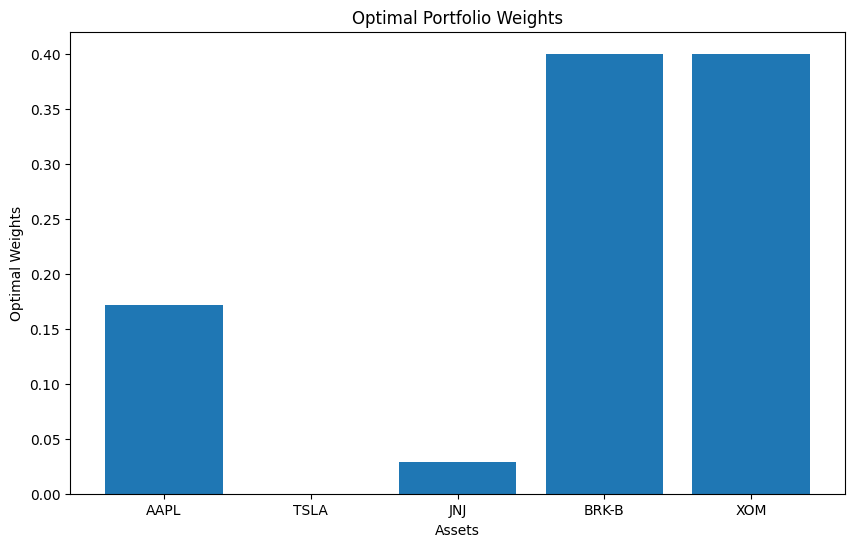

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()